In [1]:
import numpy as np
from numpy import genfromtxt
from trueskill import TrueSkill, Rating, quality_1vs1, rate_1vs1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy import stats
import operator as op
import pandas as pd
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
import math
import sys

# Rastrigin function
## Optimization Methods
---
https://www.sfu.ca/~ssurjano/schwef.html

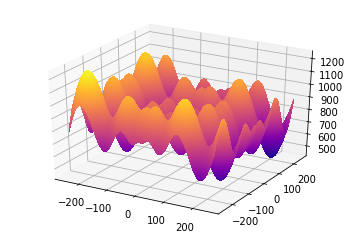

In [2]:
def schwefel(*X, **kwargs):
    A = kwargs.get('A', 2)
    # return 418.9829*A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])
    return 418.9829*A - sum([(x*np.sin(np.sqrt(np.absolute(x)))) for x in X])


    

if __name__ == '__main__':
    X = np.linspace(-250, 250, 1000)    
    Y = np.linspace(-250, 250, 1000)    

    X, Y = np.meshgrid(X, Y)

    Z = schwefel(X, Y, A=2)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    plt.savefig('schwefel', format='pdf')


## Simulated Annealing
---
### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

In [215]:
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [150]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    # out plot
    OUT_List_Simanneal = []
    Iterations = []
   
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    
    best_index=total
    best_temp=T
    for index in range(epochs):
        # print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            sys.stdout.write("\r Temperature " + str(T))
            sys.stdout.flush()
        # print("Temperature", T, "Length", length)
        for it in range(length):
            Iterations.append(total)
            total+=1
            new_solution = np.copy(old_solution)
            for y in new_solution:
                if proposalfunc == 'rdmGauss':
                    y[0] = y[0] + rdmGauss(sigma = 70)
                else:
                    y[0] = y[0] + rdmSimetricPoerLow(x1 = 200, x0 = 10, alpha = -1.5)
               
                if y[0] < -500 :
                    y[0] = -500
                elif y[0] > 500:
                    y[0] = 500
                    
            # new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                OUT_List_Simanneal.append(new_energy)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
                OUT_List_Simanneal.append(old_energy)
    
    best_meta=dict(index=best_index, temp=best_temp)
    # print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator, OUT_List_Simanneal, Iterations

In [151]:
# http://mathworld.wolfram.com/RandomNumber.html
# https://stackoverflow.com/questions/918736/random-number-generator-that-produces-a-power-law-distribution
def rdmSimetricPoerLow(x1 = 100, x0 = 10, alpha = -1.5):
    y = np.random.uniform(0,1,1)
    x = math.pow((math.pow(x1, (alpha + 1)) - math.pow(x0, (alpha + 1)))*y + math.pow(x0, (alpha + 1)),(1/(alpha+1)))
    sign = np.random.uniform(0,1,1)
    return x if sign > 0.5 else -x

In [152]:
def rdmGauss(sigma = 0.2, mu = 0):
    return np.random.normal(mu, sigma, 1)

In [153]:
def Schwefel(fevalMtx):
    dim = fevalMtx.shape[0]
    return 418.9829*dim - sum([(x[0]*np.sin(np.sqrt(np.absolute(x[0])))) for x in fevalMtx])

In [154]:
def SchwefelGradient(fevalMtx):
    delta = np.zeros((fevalMtx.shape[0], 1))
    for i in range(fevalMtx.shape[0]):
        if fevalMtx[i][0] >= 0:
            innerDerivetive = 1/(np.sqrt(fevalMtx[i][0])*2)
        else:
            innerDerivetive = -1/(np.sqrt(-fevalMtx[i][0])*2)
        delta[i][0] = -np.sin(np.sqrt(np.absolute(fevalMtx[i][0]))) - fevalMtx[i][0]*np.cos(np.sqrt(np.absolute(fevalMtx[i][0])))*innerDerivetive
   
    return delta

In [155]:
def min_SchwefelPowerLaw(fevalMtx):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmSimetricPoerLow(x1 = 200, x0 = 10, alpha = -1.5)
        
        if y[0] < -500 :
            y[0] = -500
        elif y[0] > 500:
            y[0] = 500
    
    prev = Schwefel(fevalMtx);
    new = Schwefel(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx
            

In [156]:
def min_SchwefelHill(fevalMtx):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmGauss(sigma = 70)
        
        if y[0] < -500 :
            y[0] = -500
        elif y[0] > 500:
            y[0] = 500
    
    prev = Schwefel(fevalMtx);
    new = Schwefel(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx

In [160]:
def min_SchwefelGradient(fevalMtx, delta):
    alpha = 0.5;
    miu = 0.7;
    grad = SchwefelGradient(fevalMtx)
    Y = np.copy(fevalMtx)
    for i in range(fevalMtx.shape[0]):
        delta[i][0] =  miu * delta[i][0] - grad[i][0] * alpha
        Y[i][0] = Y[i][0] + delta[i][0]
        
        if Y[i][0] < -500 :
            Y[i][0] = -500
        elif Y[i][0] > 500:
            Y[i][0] = 500
    
    
    new = Schwefel(Y);
    
    return new, Y, delta 

In [228]:
Best_List_PowerLaw = []
Best_List_HillRice = []
Best_List_Gradient = []
Best_List_GaussSimanneal = []
Best_List_PwrSimanneal = []

valVectorSize = 10
if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
avgIterations = 100

OUT_List_PowerLaw = []
OUT_List_HillRice = []
OUT_List_Gradient = []
OUT_List_PwrSimanneal = []
OUT_List_GaussSimanneal = []
    
for j in range(0, avgIterations):
    print("Iteration......................................: %i" % j)
    print("````````````````````````````````````````````````")
       
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=200, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    
    print("Initial X Set: %s" % ([",".join(item) for item in fevalRdm.astype(str)]) )

    powerLawMtx = np.copy(fevalRdm)
    hillMtx = np.copy(fevalRdm)
    gradientMtx = np.copy(fevalRdm)
    simannealMtx = np.copy(fevalRdm)
    
    
    for i in range(iterSize):
        PowerLaw_OUT, powerLawMtx = min_SchwefelPowerLaw(powerLawMtx)
        if len(OUT_List_PowerLaw) == iterSize :
            OUT_List_PowerLaw[i] = OUT_List_PowerLaw[i] + PowerLaw_OUT
        else:
            OUT_List_PowerLaw.append(PowerLaw_OUT)
        Iterations.append(i)
    #-----

    for i in range(iterSize):
        HillRice_OUT, hillMtx = min_SchwefelHill(hillMtx)
        if len(OUT_List_HillRice) == iterSize :
            OUT_List_HillRice[i] = OUT_List_HillRice[i] + HillRice_OUT
        else:
            OUT_List_HillRice.append(HillRice_OUT)
    #-----
    
    for i in range(iterSize):
        Gradient_OUT, gradientMtx, delta = min_SchwefelGradient(gradientMtx,delta)
        if len(OUT_List_Gradient) == iterSize :
            OUT_List_Gradient[i] = OUT_List_Gradient[i] + Gradient_OUT
        else:
            OUT_List_Gradient.append(Gradient_OUT)
    #-----
    print("Final PowerLaw_OUT %f Solution: %s" % (PowerLaw_OUT, [",".join(item) for item in powerLawMtx.astype(str)]))
    Best_List_PowerLaw.append(PowerLaw_OUT)
    
    print("Final HillRice_OUT %f Solution: %s" % (HillRice_OUT, [",".join(item) for item in hillMtx.astype(str)]))
    Best_List_HillRice.append(HillRice_OUT)
    
    print("Final Gradient_OUT %f Solution: %s" % (Gradient_OUT, [",".join(item) for item in gradientMtx.astype(str)]))
    Best_List_Gradient.append(Gradient_OUT)
    #-----
    inits=dict(solution=simannealMtx, length=70, T=200)
    
    bmeta, bs, be, out, OUT_List_PwrSimanneal_Tmp, Iterations_PwrSimanneal = sa(Schwefel,
                                                                            inits,
                                                                            SimannealItrSize,
                                                                            tf,
                                                                            itf,
                                                                            'rdmSimetricPoerLow')
    
    if len(OUT_List_PwrSimanneal) == 0:
        OUT_List_PwrSimanneal = [ b for b in OUT_List_PwrSimanneal_Tmp]
    else:
        OUT_List_PwrSimanneal[:] = [ (OUT_List_PwrSimanneal_Tmp[i] + OUT_List_PwrSimanneal[i]) for i in range(len(OUT_List_PwrSimanneal))]
        
    print("\n Final PwrSimanneal_OUT %f Solution: %s" % (be, [",".join(item) for item in bs.astype(str)]))
    Best_List_PwrSimanneal.append(be)
    #-----
    inits=dict(solution=simannealMtx, length=70, T=200)
    
    bmeta, bs, be, out, OUT_List_GaussSimanneal_Tmp, Iterations_GaussSimanneal = sa(Schwefel,
                                                                                inits,
                                                                                SimannealItrSize,
                                                                                tf,
                                                                                itf,
                                                                                'rdmGauss')
    
    if len(OUT_List_GaussSimanneal) == 0:
        OUT_List_GaussSimanneal = [ b for b in OUT_List_GaussSimanneal_Tmp]
    else:
        OUT_List_GaussSimanneal[:] = [ (OUT_List_GaussSimanneal_Tmp[i] + OUT_List_GaussSimanneal[i]) for i in range(len(OUT_List_GaussSimanneal))]
        
    print("\n Final GaussSimanneal_OUT %f Solution: %s" % (be, [",".join(item) for item in bs.astype(str)]))
    Best_List_GaussSimanneal.append(be)


    
OUT_List_PowerLaw[:] = [x / avgIterations for x in OUT_List_PowerLaw]

OUT_List_HillRice[:] = [x / avgIterations for x in OUT_List_HillRice]

OUT_List_Gradient[:] = [x / avgIterations for x in OUT_List_Gradient]

OUT_List_PwrSimanneal[:] = [x / avgIterations for x in OUT_List_PwrSimanneal]

OUT_List_GaussSimanneal[:] = [x / avgIterations for x in OUT_List_GaussSimanneal]





Iteration......................................: 0
````````````````````````````````````````````````
Initial X Set: ['453.66029170328846', '308.44142430471163', '453.2954477161562', '221.57615683228917', '319.43388860008713', '471.074966759357', '301.90325094675836', '229.46897520966252', '423.28329574006455', '344.8103325496397']
Final PowerLaw_OUT 706.263193 Solution: ['427.21334331566806', '223.59040115496285', '392.26298258207447', '438.59203197199787', '438.1656126425088', '435.9410749762732', '409.244174814673', '-323.7155730275796', '403.36578437197016', '426.22273382080783']
Final HillRice_OUT 956.314052 Solution: ['424.65972627399947', '387.3878195112981', '430.5211769448899', '48.090751454115164', '382.5478311840238', '432.5990778523775', '413.98219831305823', '-316.78970756128035', '397.78191071918064', '433.06171268109654']
Final Gradient_OUT 651.419135 Solution: ['420.968746359982', '420.968746359982', '420.968746359982', '203.81425264889447', '420.968746359982', '420.96874

Final PowerLaw_OUT 398.001369 Solution: ['417.5618880961711', '421.09284890937823', '204.5859060550268', '412.97844162651364', '410.659595278197', '431.6916363679774', '395.54187973976184', '403.0247551952265', '415.7962612549406', '434.30562823399225']
Final HillRice_OUT 998.315583 Solution: ['407.57390763891397', '395.2963768571361', '67.19358633065512', '396.0678044032988', '461.16992094031764', '415.32140346086993', '410.7412129724285', '431.39832652346814', '443.80937122744444', '381.445452346238']
Final Gradient_OUT 434.279466 Solution: ['420.968746359982', '420.96874635998205', '203.81425264889447', '420.968746359982', '420.968746359982', '203.81425264889447', '420.96874635998205', '420.96874635998205', '420.968746359982', '420.968746359982']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 741.000528 Solution: ['415.92610468030176', '444.6114772574414', '419.20171648675097', '403.22130702862836', '-288.0525736206338', '435.95923711432494', '-127.85561381885073', '405.554

Final PowerLaw_OUT 612.383912 Solution: ['403.2170976615227', '407.17860395330473', '413.98148890267976', '410.7598151403078', '205.15406791391092', '192.78354414580403', '421.63970856231623', '440.50009661745963', '437.2877441338132', '421.43657798188076']
Final HillRice_OUT 1437.322866 Solution: ['420.5629390083914', '229.71808340413236', '393.1578717638326', '407.69611915197754', '426.2876007019976', '205.69845262495622', '205.20547348649552', '-286.0682612069426', '410.3836409796243', '-0.8622624787132924']
Final Gradient_OUT 1737.117482 Solution: ['420.968746359982', '203.81425264889447', '203.81425264889447', '420.968746359982', '203.81425264889447', '203.81425264889447', '203.81425264889447', '203.81425264889447', '203.81425264889447', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 936.459306 Solution: ['421.8103808516661', '422.28636409279596', '-310.6082348061665', '183.65636822306283', '420.4592050417005', '434.17933253993596', '413.829737808010

Final PowerLaw_OUT 506.101415 Solution: ['435.06111782045235', '424.33919396826246', '440.1148047952183', '209.8057863434981', '424.68895032524506', '399.6942684548891', '405.2569021514188', '388.702869427692', '422.37292870307135', '417.58870396386124']
Final HillRice_OUT 984.906098 Solution: ['420.3576722106761', '203.60780993603584', '441.02240507975813', '215.38146434854366', '444.9642071375644', '222.17999336823385', '425.47474574893516', '394.2636921061968', '414.8482695848476', '442.91566422461176']
Final Gradient_OUT 217.139797 Solution: ['420.96874635998205', '203.81425264889447', '420.96874635998205', '420.96874635998205', '420.96874635998205', '420.96874635998205', '420.96874635998205', '420.96874635998205', '420.968746359982', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 1213.995038 Solution: ['-310.64013742386', '415.86076959854313', '421.68116852520006', '409.8378433696117', '224.73803874659654', '435.2862272483897', '395.700205667786', '2

Final PowerLaw_OUT 852.759689 Solution: ['441.28997631285154', '420.4079271033938', '413.91684165959055', '60.699800943474465', '193.3120348173606', '453.34879618437066', '411.72660791665544', '432.24312940580364', '409.94081011140537', '438.0672115505403']
Final HillRice_OUT 701.462207 Solution: ['403.2904543301522', '384.3735041801831', '463.48391020330695', '423.19459302228194', '423.2015881864682', '383.33249512372566', '447.8056142767407', '428.83614130824543', '408.0109571579995', '410.6652274613971']
Final Gradient_OUT 868.558805 Solution: ['420.96874635998205', '420.968746359982', '420.968746359982', '203.81425264889447', '203.81425264889447', '420.96874635998205', '203.81425264889447', '420.96874635998205', '420.96874635998205', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 1253.387491 Solution: ['426.3197045303411', '432.6280718612557', '441.9427246845313', '-36.483372162587884', '-290.16832934682816', '421.16154958307015', '-500.0', '427.23174

Final PowerLaw_OUT 1014.608947 Solution: ['416.697472454062', '201.36573858195274', '438.89110230201476', '396.78009011746036', '418.464117872741', '51.349311579790665', '403.0239886513794', '210.90666830308788', '403.77956911703524', '415.7372252165759']
Final HillRice_OUT 1430.990932 Solution: ['447.3218577705859', '-120.13799920766027', '221.6387087244215', '426.06406504683963', '465.5316009591332', '192.50415530749555', '439.81044019418175', '424.15860760212905', '219.79752389125971', '406.17622546124886']
Final Gradient_OUT 434.279466 Solution: ['420.968746359982', '203.81425264889447', '420.96874635998205', '420.968746359982', '420.968746359982', '203.8142526488945', '420.96874635998205', '420.968746359982', '420.96874635998205', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 661.482646 Solution: ['407.81321916260515', '-292.82291249333434', '207.02844107134007', '386.29781943564285', '435.712899243092', '415.527791694776', '423.08182530578966', '42

Final PowerLaw_OUT 653.841638 Solution: ['403.08780909225464', '422.2714195939231', '419.6237843205315', '405.8161832348307', '441.29198407749703', '422.25845724087264', '414.5856512899743', '423.93220267351273', '-65.39128583606154', '401.83535943660945']
Final HillRice_OUT 1254.006117 Solution: ['447.8675500658954', '418.0941784735701', '442.6477030753574', '40.46047855392436', '229.34384123817884', '419.5777864561439', '75.52881585511889', '424.08087551745876', '433.17960782653165', '414.879729680748']
Final Gradient_OUT 868.558805 Solution: ['420.968746359982', '420.968746359982', '420.968746359982', '420.96874635998205', '203.81425264889447', '420.968746359982', '203.81425264889447', '203.81425264889447', '203.81425264889447', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 908.087047 Solution: ['71.48521539028707', '428.67063487070493', '425.57517081419456', '-331.01954331186295', '408.91367310487345', '413.96597337151655', '413.7851632111597', '401.

Final PowerLaw_OUT 797.243683 Solution: ['413.7568551180179', '-292.6522125511581', '203.22674530754657', '411.82746147295063', '436.4932099411023', '428.20609855813876', '414.0278642047273', '163.6921286638157', '422.6441297373952', '413.39939313127434']
Final HillRice_OUT 1031.563245 Solution: ['453.48091206005535', '400.9990858137606', '397.74785792560755', '409.96887287971384', '220.383263645506', '463.5496448181822', '445.105510658637', '209.08776789131787', '425.28963837961504', '431.5900422491492']
Final Gradient_OUT 1085.698474 Solution: ['420.96874635998205', '203.81425264889447', '203.81425264889447', '420.96874635998205', '203.8142526488945', '203.81425264889447', '420.968746359982', '203.81425264889447', '420.96874635998205', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 830.105867 Solution: ['389.2046394417581', '446.31747695014747', '426.8191011440907', '428.0090801245798', '216.32169379460169', '414.4751134682963', '408.41319901092237', '-

Final PowerLaw_OUT 611.027616 Solution: ['414.4553028002121', '198.29231298491823', '448.2757623664979', '208.3393397090908', '403.21373262118334', '420.30405087717384', '407.1489565224779', '419.0580572802887', '419.2774132774274', '429.7889112944204']
Final HillRice_OUT 1317.457726 Solution: ['412.5962173243346', '414.3899424131338', '139.77305637892374', '396.59628445264303', '197.6092008154132', '398.185915319028', '46.524201548117354', '408.49316284499884', '432.2401480332391', '424.78907944713654']
Final Gradient_OUT 868.558805 Solution: ['420.96874635998205', '420.96874635998205', '203.81425264889447', '203.81425264889447', '203.81425264889447', '420.968746359982', '203.81425264889447', '420.968746359982', '420.968746359982', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 659.098669 Solution: ['441.2708218836427', '-314.3257491230125', '195.8618267565965', '421.2319727121619', '-293.5161609898161', '413.8921106656043', '420.5148344760226', '395.587

Final PowerLaw_OUT 695.632556 Solution: ['-319.65697347033745', '409.43001662829835', '409.2451714429456', '393.13431455763674', '419.19030214016556', '199.32051198544823', '452.61932448988154', '419.6314168118651', '414.64411200951747', '444.1513989110761']
Final HillRice_OUT 702.778554 Solution: ['414.87744487146506', '435.69897703972515', '192.0450356730748', '413.24718513488625', '442.4443147218716', '419.6052327709088', '416.72179082571614', '363.72627157834387', '410.2445962187945', '409.6741060208826']
Final Gradient_OUT 434.279466 Solution: ['203.81425264889447', '420.96874635998205', '203.81425264889447', '420.968746359982', '420.96874635998205', '420.968746359982', '420.96874635998205', '420.96874635998205', '420.968746359982', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 882.753116 Solution: ['212.2634243616391', '426.6027154253985', '431.94401019871754', '408.4878844963823', '438.1239349101892', '202.1525382263714', '196.97123002290982', '39

Final PowerLaw_OUT 370.392565 Solution: ['418.05026152283415', '437.2097245180899', '411.4715807118785', '437.1638264810132', '434.7286830599264', '434.4667283511973', '409.5418858134431', '425.31208137530274', '430.4077828535997', '-330.7645562029383']
Final HillRice_OUT 891.153511 Solution: ['432.06192762652415', '398.4667385022277', '437.476051537694', '391.06164055337683', '433.807226702996', '379.24397779185813', '457.07875598697876', '418.4703346129076', '434.49758922039973', '225.47688996818687']
Final Gradient_OUT 651.419135 Solution: ['420.968746359982', '420.96874635998205', '203.8142526488945', '420.96874635998205', '203.81425264889447', '420.96874635998205', '420.968746359982', '420.96874635998205', '420.96874635998205', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 615.614949 Solution: ['410.6936619833032', '407.87694023718365', '-99.44381918190149', '419.44943672353895', '434.7158888919895', '-280.2664756938776', '413.55065653269395', '420.

Final PowerLaw_OUT 1200.935626 Solution: ['428.9107843615449', '419.59422261770476', '192.37434998906213', '203.4751310996012', '194.7874680246926', '421.4169293884262', '86.18738116046904', '448.47655166811495', '420.909915326402', '431.8575905770432']
Final HillRice_OUT 859.903562 Solution: ['452.90176748668546', '409.995980280346', '410.53785177109637', '174.27600898920838', '435.7399072746561', '416.3412005407846', '440.7287822881627', '441.99921676715024', '215.98779836599672', '434.2109185563811']
Final Gradient_OUT 651.419135 Solution: ['420.96874635998205', '420.968746359982', '203.81425264889447', '420.96874635998205', '203.81425264889447', '420.96874635998205', '203.81425264889447', '420.968746359982', '420.96874635998205', '420.968746359982']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 1033.233537 Solution: ['204.86356419161237', '-285.0228085527288', '435.69921221937057', '-307.85689405823183', '206.38654031545843', '447.7934288680141', '400.2069451794691', '-29

Final PowerLaw_OUT 680.927925 Solution: ['398.2517737270901', '407.9726536962724', '412.8823738244221', '435.91420401243954', '219.7108688422354', '414.31389126637384', '411.61315810906575', '180.3782492608646', '430.9093558869204', '417.9607136669828']
Final HillRice_OUT 956.366325 Solution: ['434.5072554828531', '229.08844076750222', '207.40640165145302', '207.98184460053346', '439.1220545152398', '399.26427349616455', '414.5182626460221', '406.282198727147', '422.6123581711571', '444.605637515364']
Final Gradient_OUT 434.279466 Solution: ['420.96874635998205', '203.81425264889447', '420.96874635998205', '420.96874635998205', '203.81425264889447', '420.968746359982', '420.96874635998205', '420.96874635998205', '420.968746359982', '420.968746359982']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 225.753558 Solution: ['417.1406193501498', '415.7602069649056', '423.1006716647846', '437.50751992232586', '434.25610422422807', '444.5988320345273', '396.6131830511906', '426.492903

Final PowerLaw_OUT 1171.633128 Solution: ['173.05896490545885', '412.50207312369787', '408.8502034718632', '438.1484552089295', '205.23279756632624', '216.73975625022405', '407.7218607005989', '211.40306422612557', '442.09468175361667', '406.2139024134452']
Final HillRice_OUT 1257.680447 Solution: ['410.8715977823601', '60.337389999661426', '428.428697459536', '447.3578311428115', '396.1717088968684', '228.74240087561975', '419.1054327292319', '208.55969647802866', '387.8483407779801', '445.83414974075936']
Final Gradient_OUT 1085.698474 Solution: ['203.81425264889447', '203.81425264889447', '420.968746359982', '420.968746359982', '420.968746359982', '203.81425264889447', '420.96874635998205', '203.81425264889447', '420.968746359982', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 535.650650 Solution: ['404.8629751296448', '-307.2368809982577', '438.9592346307293', '417.4961318374251', '408.6644977884395', '-313.5570355557498', '420.5646883121987', '381.5

Final PowerLaw_OUT 541.007332 Solution: ['426.1778543996373', '417.3046451955265', '437.1773049475034', '419.56811377727837', '446.48097311775825', '408.4413871806105', '-281.7430362037682', '420.2024792508442', '427.95795883455406', '195.53816883727507']
Final HillRice_OUT 1315.783643 Solution: ['397.2582563215241', '448.2171101917631', '458.7343833884705', '420.21124744057107', '212.74236409770984', '198.9858155559861', '225.41589321226883', '410.88721394193607', '436.9219481153742', '207.763802637259']
Final Gradient_OUT 1085.698474 Solution: ['420.96874635998205', '420.968746359982', '420.96874635998205', '420.968746359982', '203.81425264889447', '203.81425264889447', '203.81425264889447', '420.96874635998205', '203.81425264889447', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 627.953645 Solution: ['422.2010141958157', '444.59467373883706', '427.8403823009576', '430.3568615322446', '429.2833912495486', '-295.33763631576176', '181.41295321444198', '4

Final PowerLaw_OUT 394.522581 Solution: ['420.4813031322503', '427.3014163362158', '398.86855751647727', '401.4104953514766', '418.1431581626186', '415.208916438187', '424.9284216391153', '411.3127499906186', '406.8002605923454', '216.99512148756196']
Final HillRice_OUT 929.656665 Solution: ['392.27369471852734', '417.02449967963344', '396.99113988536595', '223.19708825335692', '409.55349231491255', '390.03588943177846', '421.24291707804866', '390.77633916330353', '185.85455449279243', '423.88642670205076']
Final Gradient_OUT 434.279466 Solution: ['420.96874635998205', '420.968746359982', '420.968746359982', '203.81425264889447', '420.968746359982', '420.96874635998205', '420.96874635998205', '420.96874635998205', '203.8142526488945', '420.96874635998205']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 444.432175 Solution: ['212.95986805287396', '415.579018988478', '438.33238906667657', '408.0148511412936', '419.6084118980493', '432.77101373231767', '428.2890752344674', '413.4

Final PowerLaw_OUT 1111.722442 Solution: ['197.71778250687996', '429.35684664953135', '435.9459861981995', '204.4549746561976', '417.4967739913526', '454.74800654391686', '188.44752539662568', '199.35939852791734', '430.1803170526455', '433.5055222431464']
Final HillRice_OUT 980.985926 Solution: ['421.5425686686267', '404.0371387111492', '428.94903481666995', '395.8034784118187', '216.81789206558207', '395.26890143254826', '425.3289739906722', '181.9749593131329', '422.17653781914146', '183.58458785797197']
Final Gradient_OUT 1519.977813 Solution: ['203.81425264889447', '420.96874635998205', '420.968746359982', '203.81425264889447', '203.81425264889447', '420.968746359982', '203.81425264889447', '203.81425264889447', '203.81425264889447', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 619.192230 Solution: ['425.8489406243251', '412.6036372780463', '448.77535878743595', '444.1001829687553', '197.87569336612293', '437.2262961354032', '408.3803224469857', '4

Final PowerLaw_OUT 517.347042 Solution: ['428.2534820774571', '423.58225272892355', '442.8392594884098', '411.8774352695732', '426.6201207900689', '426.0806348260992', '184.13460882970827', '398.7975301593305', '410.6986366450321', '448.9078629288066']
Final HillRice_OUT 1532.951392 Solution: ['-44.210832654641216', '-138.68027246881738', '-111.63081262271955', '426.31026614601984', '420.9602331822587', '406.737849376169', '432.19833806455387', '64.42287769580902', '412.65901127818825', '441.27266623717605']
Final Gradient_OUT 651.419135 Solution: ['420.96874635998205', '203.81425264889447', '203.81425264889447', '420.96874635998205', '420.968746359982', '420.968746359982', '420.96874635998205', '203.81425264889447', '420.96874635998205', '420.968746359982']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 327.118878 Solution: ['446.1177362761101', '401.3227757732153', '414.5354348002584', '438.5633501030476', '421.6118727235017', '431.7225560815411', '399.62529716849843', '422.

Final PowerLaw_OUT 878.351077 Solution: ['392.0322068004744', '415.77005302819816', '412.10981762821', '420.45800096763094', '205.84392747504597', '195.10505097745153', '407.6816445398147', '413.17048333475765', '433.4681001854686', '182.46263798116019']
Final HillRice_OUT 616.496705 Solution: ['388.54046999119214', '435.33556042442825', '458.9396244708594', '406.6920909609056', '443.1461910039141', '435.30392184382964', '427.8719493878941', '399.9422792175965', '393.00706269244154', '405.81110618305814']
Final Gradient_OUT 651.419135 Solution: ['420.96874635998205', '420.968746359982', '420.968746359982', '420.96874635998205', '203.81425264889447', '203.81425264889447', '420.968746359982', '420.96874635998205', '420.96874635998205', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 437.355789 Solution: ['423.09784451140206', '442.5877244922224', '413.9015819775653', '420.0212957860219', '406.78308631643995', '417.41279371845536', '420.7021929755599', '424.0

Final PowerLaw_OUT 652.794346 Solution: ['433.9384166570549', '431.005787376428', '190.04701774987302', '432.80850853853997', '412.7688620463855', '428.64341674669123', '414.8877615323205', '435.4850116472416', '448.80459288633875', '200.34847475472085']
Final HillRice_OUT 1219.252769 Solution: ['202.86186094097974', '469.8965314700075', '446.71430414243594', '421.5545710550662', '149.2767508784682', '414.33763137849553', '408.56207594766187', '394.5944171137724', '441.72558890605745', '431.60870494631877']
Final Gradient_OUT 651.419135 Solution: ['420.968746359982', '420.96874635998205', '420.968746359982', '203.81425264889447', '420.96874635998205', '420.968746359982', '203.81425264889447', '420.968746359982', '420.968746359982', '203.81425264889447']
 Temperature 3.6028797018964003
 Final PwrSimanneal_OUT 902.474282 Solution: ['394.25079523843647', '416.75243730486943', '-308.6095005448286', '409.14648301811025', '426.0659883904835', '194.14779824813482', '-123.71709017015905', '437

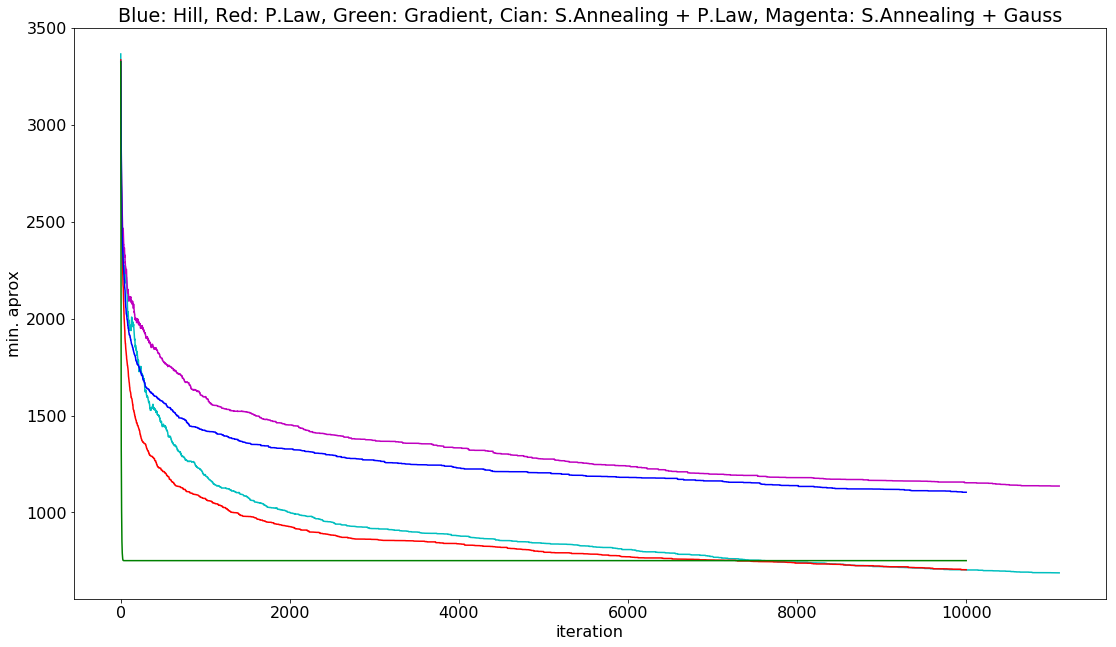

In [235]:
# plot the cost
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations_PwrSimanneal),
         np.squeeze(OUT_List_PwrSimanneal),
         'c-',
         np.squeeze(Iterations_GaussSimanneal),
         np.squeeze(OUT_List_GaussSimanneal),
         'm-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_PowerLaw),
         'r-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_HillRice),
         'b-',
         np.squeeze(Iterations),
         np.squeeze(OUT_List_Gradient),
         'g-',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("Blue: Hill, Red: P.Law, Green: Gradient, Cian: S.Annealing + P.Law, Magenta: S.Annealing + Gauss")
plt.savefig('schwefelMinCureveII.pdf', format='pdf')
plt.show()


Best PowerLaw mean 704.440656: 
Best PowerLaw std 247.189693: 


<function matplotlib.pyplot.show(*args, **kw)>

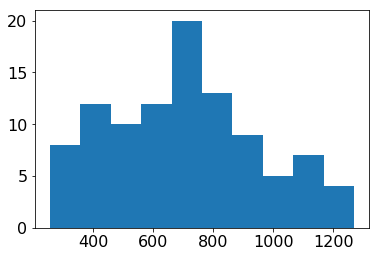

In [236]:
print("Best PowerLaw mean %f: " % np.mean(Best_List_PowerLaw))
print("Best PowerLaw std %f: " % np.std(Best_List_PowerLaw))
plt.hist(Best_List_PowerLaw)
plt.show

Best HillRice mean 1104.416691: 
Best HillRice std 308.832282: 


<function matplotlib.pyplot.show(*args, **kw)>

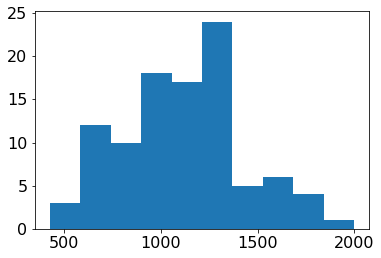

In [237]:
print("Best HillRice mean %f: " % np.mean(Best_List_HillRice))
print("Best HillRice std %f: " % np.std(Best_List_HillRice))
plt.hist(Best_List_HillRice)
plt.show

Best Gradient mean 751.303383: 
Best Gradient std 327.038582: 


<function matplotlib.pyplot.show(*args, **kw)>

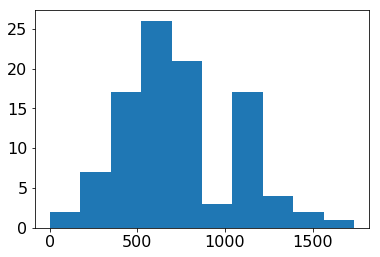

In [238]:
print("Best Gradient mean %f: " % np.mean(Best_List_Gradient))
print("Best Gradient std %f: " % np.std(Best_List_Gradient))
plt.hist(Best_List_Gradient)
plt.show

Best Best_List_PwrSimanneal mean 688.146345: 
Best Best_List_PwrSimanneal std 251.705462: 


<function matplotlib.pyplot.show(*args, **kw)>

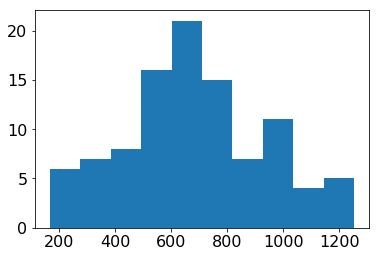

In [239]:
print("Best Best_List_PwrSimanneal mean %f: " % np.mean(Best_List_PwrSimanneal))
print("Best Best_List_PwrSimanneal std %f: " % np.std(Best_List_PwrSimanneal))
plt.hist(Best_List_PwrSimanneal)
plt.show

Best Best_List_GaussSimanneal mean 1136.163108: 
Best Best_List_GaussSimanneal std 328.580904: 


<function matplotlib.pyplot.show(*args, **kw)>

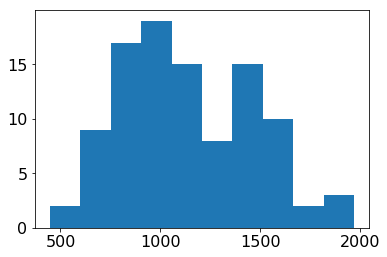

In [240]:
print("Best Best_List_GaussSimanneal mean %f: " % np.mean(Best_List_GaussSimanneal))
print("Best Best_List_GaussSimanneal std %f: " % np.std(Best_List_GaussSimanneal))
plt.hist(Best_List_GaussSimanneal)
plt.show

In [144]:

for i in range(20):
    print(rdmSimetricPoerLow(x1 = 200, x0 = 10, alpha = -1.5))

172.7532968354202
-39.05948051006026
-36.26459886430228
-43.40284013252627
20.1525296155341
-94.74155401916224
-47.72517372057513
-29.879795680337335
-188.57870848244093
96.17132674123692
19.32705085604737
-22.06488273816991
-28.988122004944863
-14.612099065006904
-16.74705877718569
18.50259007887875
143.49257561245963
-17.370316992964405
-115.8560740469735
-17.427301619650052
